# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from IPython.display import Image

# Importing different tables

In [2]:
df_waste = pd.read_excel("Modelo_Residuos_2019.xlsx", engine="openpyxl", sheet_name = "Hoja1")
df_homes = pd.read_excel("Tamaño de los hogares 2019.xlsx", engine="openpyxl", sheet_name = "Tamaño por distritos")
df_income = pd.read_excel("Distribución de renta de los hogares 17-18.xlsx", engine="openpyxl", sheet_name = "Distrito")
#df_vul = pd.read_excel("Ranking_Vulnerabilidad_AHP_2019.xlsx", engine="openpyxl", sheet_name = "aux.2")

In [3]:
display(df_waste.head(2))
display(df_homes.head(2))
display(df_income.head(2))

,LOTE,DISTRITO,FRACCIÓN,ENERO '19(TN),FEBRERO '19(TN),MARZO '19(TN),ABRIL '19(TN),MAYO '19(TN),JUNIO'19(TN),JULIO'19(TN),AGOSTO'19(TN),SEPTIEMBRE'19(TN),OCTUBRE'19(TN),NOVIEMBRE'19(TN),DICIEMBRE'19(TN)
0,1,01. CENTRO,RESTO,6099.24,5643.16,6358.28,5923.36,6361.46,6244.32,5935.02,4864.96,5831.70,6375.5,6133.30,6593.32
1,1,01. CENTRO,ENVASES,201.66,191.92,219.30,205.92,225.40,222.86,205.70,177.78,225.74,238.3,229.12,238.16


,Id Distrito,Distrito / Sección,Habitantes,Total Hogares,Tamaño medio del hogar
0,1,01. Centro,134881,67296,2.004294
1,2,02. Arganzuela,153830,65005,2.366433


,Distrito,Renta media por persona,Renta media por hogar
0,01. Centro,17932,36072.0
1,02. Arganzuela,18473,43789.0


# Cleaning waste table

In [4]:
df_waste.dtypes

LOTE                   int64
DISTRITO              object
FRACCIÓN              object
ENERO '19(TN)        float64
FEBRERO '19(TN)      float64
MARZO '19(TN)        float64
ABRIL '19(TN)        float64
MAYO '19(TN)         float64
JUNIO'19(TN)         float64
JULIO'19(TN)         float64
AGOSTO'19(TN)        float64
SEPTIEMBRE'19(TN)    float64
OCTUBRE'19(TN)       float64
NOVIEMBRE'19(TN)     float64
DICIEMBRE'19(TN)     float64
dtype: object

In [5]:
df_waste['years waste'] = df_waste.iloc[:,3:15].sum(axis=1)

In [6]:
df_waste.columns

Index(['LOTE ', 'DISTRITO', 'FRACCIÓN', 'ENERO '19(TN)', 'FEBRERO '19(TN)',
       'MARZO '19(TN)', 'ABRIL '19(TN)', 'MAYO '19(TN)', 'JUNIO'19(TN)',
       'JULIO'19(TN)', 'AGOSTO'19(TN)', 'SEPTIEMBRE'19(TN)', 'OCTUBRE'19(TN)',
       'NOVIEMBRE'19(TN)', 'DICIEMBRE'19(TN)', 'years waste'],
      dtype='object')

In [7]:
df_waste = df_waste[['DISTRITO', 'FRACCIÓN', 'years waste']]
df_waste = df_waste.rename(columns={'DISTRITO':'district', 'FRACCIÓN':'waste_type','years waste':'yearly_waste'})
df_waste.head()

,district,waste_type,yearly_waste
0,01. CENTRO,RESTO,72363.62
1,01. CENTRO,ENVASES,2581.86
2,01. CENTRO,VIDRIO,8155.40
3,01. CENTRO,CLINICOS,1904.58
4,01. CENTRO,ORGÁNICA,0.00


In [8]:
df_waste[['district_id', 'district_name']] = df_waste['district'].str.split('.', expand=True)

In [9]:
df_waste = df_waste.drop(['district'], axis= 1)

In [10]:
df_waste = df_waste[['district_id', 'district_name', 'waste_type', 'yearly_waste']]

In [11]:
def items_lower(df):
    df_cat = df.select_dtypes(['object'])
    for i in df_cat.columns:
        df[i] = list(map(lambda x: x.lower(), df[i]))
    return df

In [12]:
df_waste = items_lower(df_waste)

In [13]:
def accent_replace(df):
    df_cat = df.select_dtypes(['object'])
    for i in df_cat.columns:
        df[i]=df[i].str.replace('á', 'a')
        df[i]=df[i].str.replace('é', 'e')
        df[i]=df[i].str.replace('í', 'i')
        df[i]=df[i].str.replace('ó', 'o')
        df[i]=df[i].str.replace('ú', 'u')


    return df

In [14]:
df_waste = accent_replace(df_waste)

In [15]:
df_waste

,district_id,district_name,waste_type,yearly_waste
0,01,centro,resto,72363.62
1,01,centro,envases,2581.86
2,01,centro,vidrio,8155.40
3,01,centro,clinicos,1904.58
4,01,centro,organica,0.00
...,...,...,...,...
101,21,barajas,resto,17023.36
102,21,barajas,envases,1932.16
103,21,barajas,vidrio,1571.46
104,21,barajas,puntos limpios,299.72


# Cleaning household size table

In [16]:
df_homes.dtypes

Id Distrito                 int64
Distrito / Sección         object
Habitantes                  int64
Total Hogares               int64
Tamaño medio del hogar    float64
dtype: object

In [17]:
df_homes.columns

Index(['Id Distrito', 'Distrito / Sección', 'Habitantes', 'Total Hogares',
       'Tamaño medio del hogar'],
      dtype='object')

In [18]:
df_homes[['district_id', 'district_name']] = df_homes['Distrito / Sección'].str.split('.', expand=True)

In [19]:
df_homes = df_homes.drop(['Id Distrito', 'Distrito / Sección'], axis=1)

In [20]:
df_homes = df_homes.rename(columns={'Habitantes':'residents', 'Total Hogares':'households','Tamaño medio del hogar':'avg_household_size'})
df_homes = df_homes[['district_id', 'district_name', 'residents', 'households', 'avg_household_size']]

In [21]:
df_homes['avg_household_size']= round(df_homes['avg_household_size'],2)

In [22]:
df_homes = items_lower(df_homes)
df_homes = accent_replace(df_homes)

In [23]:
df_homes.head(3)

,district_id,district_name,residents,households,avg_household_size
0,01,centro,134881,67296,2.00
1,02,arganzuela,153830,65005,2.37
2,03,retiro,119379,48673,2.45


# Cleaning Household income distribution table

In [24]:
df_income[['district_id', 'district_name']] = df_income['Distrito'].str.split('.', expand=True)

In [25]:
df_income = df_income.drop(['Distrito'], axis=1)

In [26]:
df_income.columns

Index(['Renta media por persona ', 'Renta media por hogar', 'district_id',
       'district_name'],
      dtype='object')

In [27]:
df_income = df_income.rename(columns={'Renta media por persona ':'avg_income_person', 'Renta media por hogar':'Avg_household_income'})
df_income = df_income[['district_id', 'district_name', 'avg_income_person', 'Avg_household_income']]

In [28]:
df_income = items_lower(df_income)
df_income = accent_replace(df_income)

In [29]:
df_income.head(3)

,district_id,district_name,avg_income_person,Avg_household_income
0,01,centro,17932,36072.0
1,02,arganzuela,18473,43789.0
2,03,retiro,22706,55775.0


# Saving files to link tables in SQL

In [30]:
#df_homes.to_csv('Household_size.csv', index = False)
#df_income.to_csv('Household_income.csv', index = False)
#df_waste.to_csv('waste_per_district.csv', index = False)

# Importing table from SQL

In [31]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [32]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/project1'
engine = create_engine(connection_string)
query = '''SELECT w.district_id, w.district_name, w.waste_type, w.yearly_waste, i.avg_income_person, i.Avg_household_income, s.residents, s.households, s.avg_household_size 
FROM waste_per_district w
JOIN household_income i
USING (district_id)
JOIN household_size s
USING (district_id);'''

df = pd.read_sql_query(query, engine)
df.head()

,district_id,district_name,waste_type,yearly_waste,avg_income_person,Avg_household_income,residents,households,avg_household_size
0,1,centro,resto,72364,17932,36072.0,134881,67296,2.0
1,1,centro,envases,2582,17932,36072.0,134881,67296,2.0
2,1,centro,vidrio,8155,17932,36072.0,134881,67296,2.0
3,1,centro,clinicos,1905,17932,36072.0,134881,67296,2.0
4,1,centro,organica,0,17932,36072.0,134881,67296,2.0


In [33]:
df.shape

(106, 9)

In [34]:
df1 = df.groupby(['district_name']).agg({'district_id':np.mean, 'yearly_waste': sum, 'avg_income_person':np.mean, 'Avg_household_income':np.mean,'residents':np.mean, 'households':np.mean, 'avg_household_size':np.mean}).reset_index()
df1['district_id'] = list(map(lambda x: int(x), df1['district_id']))

In [35]:
df1

,district_name,district_id,yearly_waste,avg_income_person,Avg_household_income,residents,households,avg_household_size
0,arganzuela,2,42970,18473.0,43789.0,153830.0,65005.0,2.37
1,barajas,21,21017,18514.0,49615.0,48972.0,18269.0,2.68
2,carabanchel,11,75869,11327.0,29842.0,253040.0,95680.0,2.64
3,centro,1,85006,17932.0,36072.0,134881.0,67296.0,2.00
4,chamartin,5,48791,28190.0,70735.0,145865.0,58240.0,2.50
5,chamberi,7,46282,24112.0,54327.0,139448.0,62013.0,2.25
6,ciudad lineal,15,62649,15815.0,39425.0,216270.0,86658.0,2.50
7,fuencarral,8,78917,19551.0,52858.0,246021.0,90495.0,2.72
8,hortaleza,16,58331,19759.0,52944.0,188267.0,70099.0,2.69
9,latina,10,67966,12749.0,31872.0,238154.0,95217.0,2.50


In [36]:
correlations_matrix = df1.corr()
correlations_matrix

,district_id,yearly_waste,avg_income_person,Avg_household_income,residents,households,avg_household_size
district_id,1.000000,-0.264397,-0.547623,-0.407864,-0.185071,-0.332544,0.720836
yearly_waste,-0.264397,1.000000,-0.093272,-0.148965,0.764927,0.806240,-0.224388
avg_income_person,-0.547623,-0.093272,1.000000,0.972014,-0.206315,-0.116419,-0.456823
Avg_household_income,-0.407864,-0.148965,0.972014,1.000000,-0.202078,-0.160827,-0.240526
residents,-0.185071,0.764927,-0.206315,-0.202078,1.000000,0.975110,0.056193
households,-0.332544,0.806240,-0.116419,-0.160827,0.975110,1.000000,-0.163612
avg_household_size,0.720836,-0.224388,-0.456823,-0.240526,0.056193,-0.163612,1.000000


Correlation Matrix--> There is a very high correlation between the number of people and the amount of waste

Since yearly waste is in tons, decimals do matter, thats why I create a new column for size in households so I can do good analysis

In [37]:
df1['avg_household_residents']= df1['residents']/df1['households']

In [38]:
df1 = df1.drop(['avg_household_size'],axis=1)

I create a column to compare how much waste do residents make in the different districts and another one to compare how much the make in each one

In [39]:
df1['yearly_waste_resident'] = df1['yearly_waste']/df1['residents']

In [40]:
df1['waste_per_home'] = df1['avg_household_residents']*df1['yearly_waste_resident']

In [41]:
df1

,district_name,district_id,yearly_waste,avg_income_person,Avg_household_income,residents,households,avg_household_residents,yearly_waste_resident,waste_per_home
0,arganzuela,2,42970,18473.0,43789.0,153830.0,65005.0,2.366433,0.279334,0.661026
1,barajas,21,21017,18514.0,49615.0,48972.0,18269.0,2.680606,0.429164,1.150419
2,carabanchel,11,75869,11327.0,29842.0,253040.0,95680.0,2.644649,0.299830,0.792945
3,centro,1,85006,17932.0,36072.0,134881.0,67296.0,2.004294,0.630230,1.263166
4,chamartin,5,48791,28190.0,70735.0,145865.0,58240.0,2.504550,0.334494,0.837758
5,chamberi,7,46282,24112.0,54327.0,139448.0,62013.0,2.248690,0.331894,0.746327
6,ciudad lineal,15,62649,15815.0,39425.0,216270.0,86658.0,2.495673,0.289680,0.722945
7,fuencarral,8,78917,19551.0,52858.0,246021.0,90495.0,2.718614,0.320773,0.872059
8,hortaleza,16,58331,19759.0,52944.0,188267.0,70099.0,2.685730,0.309831,0.832123
9,latina,10,67966,12749.0,31872.0,238154.0,95217.0,2.501171,0.285387,0.713801


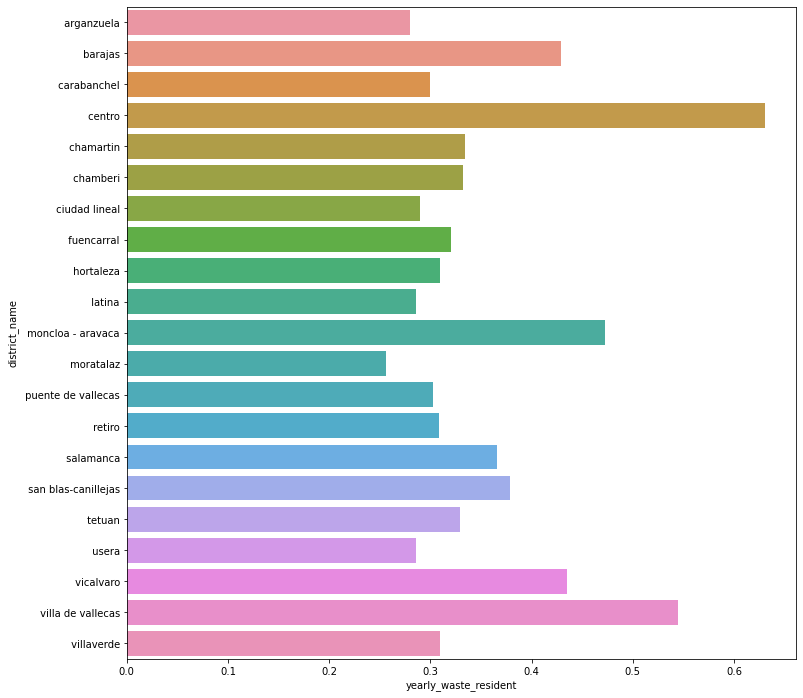

In [42]:
fig, ax = plt.subplots(figsize=(12,12))
sns.barplot(x="yearly_waste_resident", y='district_name', data=df1)
#ax.get_legend_handles_labels()
plt.show()

We can see that the district 'centro' is clearly the one that produces the most waste followedc by 'villa de vallecas' and 'moncloa-aravaca', the other district are much close to the mean

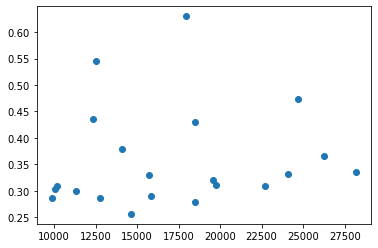

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df1['avg_income_person'], df1['yearly_waste_resident'])
plt.show()

We can see that there is not much relation with the avg income per person and the amount of waste they produce

# Checking outliers

# Villa de vallecas

After some research I discover from El País a well know newspaper in Spain, that they where taking waste to Villa de Vallecas from other parts of the South of Madrid. I have checked the information with different newspapers.
Here is a translated extract from the new:

Link to the new: 'https://elpais.com/espana/madrid/2021-06-26/la-justicia-declara-ilegal-el-traslado-masivo-de-las-toneladas-de-basuras-de-madrid-a-valdemingomez.html'

'31 municipalities of the Mancomunidad del Este agreed to take all their waste to the Villa de Vallecas landfill - Valdemingómez Technology Park - because there was no more space in the full Alcalá landfill. It was an unprecedented decision. The residents of the south of the capital began to breathe the smells. More than 30,000 extra tonnes a year, according to figures from Madrid City Council'.

In [44]:
def villadevallecas(x):
    if x == 60143:
        return x-30000
    else:
        return x

df1['yearly_waste'] = df1['yearly_waste'].apply(villadevallecas)

In [45]:
df1['yearly_waste_resident'] = df1['yearly_waste']/df1['residents']
df1['waste_per_home'] = df1['avg_household_residents']*df1['yearly_waste_resident']

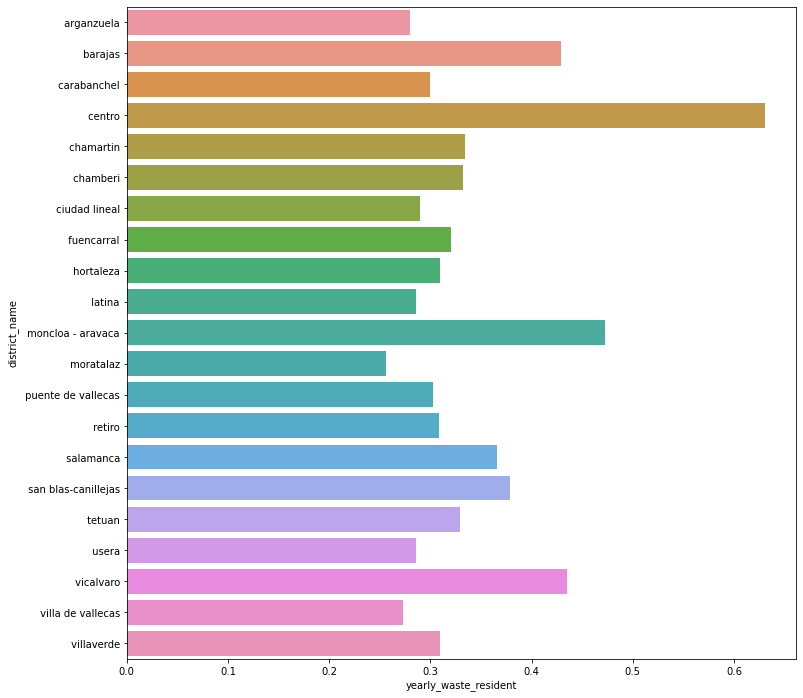

Mean value is: 0.34424975898822324


In [46]:
fig, ax = plt.subplots(figsize=(12,12))
sns.barplot(x="yearly_waste_resident", y='district_name', data=df1)
#ax.get_legend_handles_labels()
plt.show()
print('Mean value is:', df1['yearly_waste_resident'].mean())

We can see that once we drop the surplus that villa de vallecas recibes, is much closser to the mean value.

# Barajas

Barajas is clearly the other outlier of the graph. But in this case in more intuitive, in Barajas is located the Airport of Madrid, the one that receives more people in Spain, with 62 millions passangers in 2019 

From different sources I found that the airport of Madrid generates 10.000 tons a year of waste.

In [47]:
def airport(x):
    if x == 21017:
        return x-10000
    else:
        return x

df1['yearly_waste'] = df1['yearly_waste'].apply(airport)

In [48]:
df1['yearly_waste_resident'] = df1['yearly_waste']/df1['residents']
df1['waste_per_home'] = df1['avg_household_residents']*df1['yearly_waste_resident']

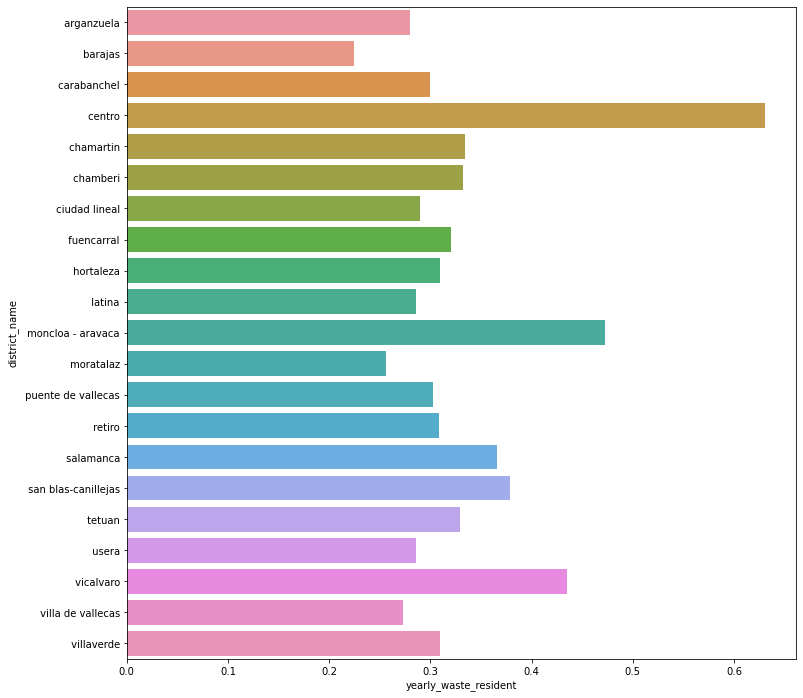

Mean value is: 0.3345260295879439


In [49]:
fig, ax = plt.subplots(figsize=(12,12))
sns.barplot(x="yearly_waste_resident", y='district_name', data=df1)
#ax.get_legend_handles_labels()
plt.show()
print('Mean value is:', df1['yearly_waste_resident'].mean())

In [50]:
df1.to_csv('CleanedWaste_round2.csv', index = False)

In [51]:
correlations_matrix = df1.corr()
correlations_matrix

,district_id,yearly_waste,avg_income_person,Avg_household_income,residents,households,avg_household_residents,yearly_waste_resident,waste_per_home
district_id,1.000000,-0.374295,-0.547623,-0.407864,-0.185071,-0.332544,0.720381,-0.341968,-0.092682
yearly_waste,-0.374295,1.000000,-0.026999,-0.087488,0.813706,0.861238,-0.250388,0.454385,0.386975
avg_income_person,-0.547623,-0.026999,1.000000,0.972014,-0.206315,-0.116419,-0.460369,0.221014,0.100815
Avg_household_income,-0.407864,-0.087488,0.972014,1.000000,-0.202078,-0.160827,-0.244621,0.116668,0.079619
residents,-0.185071,0.813706,-0.206315,-0.202078,1.000000,0.975110,0.056115,-0.132700,-0.129006
households,-0.332544,0.861238,-0.116419,-0.160827,0.975110,1.000000,-0.163751,-0.021201,-0.098343
avg_household_residents,0.720381,-0.250388,-0.460369,-0.244621,0.056115,-0.163751,1.000000,-0.465842,-0.096223
yearly_waste_resident,-0.341968,0.454385,0.221014,0.116668,-0.132700,-0.021201,-0.465842,1.000000,0.917851
waste_per_home,-0.092682,0.386975,0.100815,0.079619,-0.129006,-0.098343,-0.096223,0.917851,1.000000


# Moncloa-Aravaca

This is where a good knowledge of your city comes in, I was wondering why this district is an outlier when it comes to waste per person.
But then I realice that in this district is where 'ciudad universitaria' is. 'Ciudad universitaria' is translated as 'University City', so is the district with most universities by far. Let's analyse it

In [52]:
df_uni = pd.read_excel("universidades.xlsx", engine="openpyxl", sheet_name = "universidades")

In [53]:
df_uni = df_uni[['NOMBRE', 'COD-DISTRITO']]

In [54]:
df_uni

,NOMBRE,COD-DISTRITO
0,Centro de Enseñanza Superior Cardenal Cisneros,4.0
1,Centro de Enseñanza Superior en Humanidades y ...,9.0
2,Centro de Enseñanza Superior Villanueva,8.0
3,Centro Superior de Diseño y Moda de Madrid,14.0
4,Centro Superior de Estudios Universitarios La ...,9.0
...,...,...
128,Universidad Pontificia Comillas. Facultad de D...,1.0
129,Universidad Pontificia Comillas. Facultad de T...,8.0
130,Universidad Pontificia de Comillas. Facultad d...,1.0
131,Universidad Pontificia de Comillas. Facultad d...,1.0


In [55]:
df_uni = df_uni.dropna()
df_uni.isna().sum()


NOMBRE          0
COD-DISTRITO    0
dtype: int64

In [56]:
df_uni['COD-DISTRITO'] = list(map(lambda x: int(x), df_uni['COD-DISTRITO']))

C:\Users\gonza\AppData\Local\Temp/ipykernel_4848/1539918662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uni['COD-DISTRITO'] = list(map(lambda x: int(x), df_uni['COD-DISTRITO']))


In [57]:
df_uni

,NOMBRE,COD-DISTRITO
0,Centro de Enseñanza Superior Cardenal Cisneros,4
1,Centro de Enseñanza Superior en Humanidades y ...,9
2,Centro de Enseñanza Superior Villanueva,8
3,Centro Superior de Diseño y Moda de Madrid,14
4,Centro Superior de Estudios Universitarios La ...,9
...,...,...
128,Universidad Pontificia Comillas. Facultad de D...,1
129,Universidad Pontificia Comillas. Facultad de T...,8
130,Universidad Pontificia de Comillas. Facultad d...,1
131,Universidad Pontificia de Comillas. Facultad d...,1


In [58]:
#df_uni = df_uni.groupby(index= ['COD-DISTRITO'], aggfunc = ['count'])
df_uni = df_uni.groupby(['COD-DISTRITO']).size().reset_index(name='university_centers')
df_uni

,COD-DISTRITO,university_centers
0,1,10
1,2,1
2,3,1
3,4,3
4,5,7
5,7,19
6,8,17
7,9,63
8,10,1
9,11,1


In [59]:
df_uni = df_uni.rename(columns={'COD-DISTRITO':'district_id'})

In [60]:
df_uni

,district_id,university_centers
0,1,10
1,2,1
2,3,1
3,4,3
4,5,7
5,7,19
6,8,17
7,9,63
8,10,1
9,11,1


In [61]:
df_uni.to_csv('universities_district.csv', index = False)

As a conclusion we can say that is it clear that the big amount of university centers influence because there are more than 3 times university centers than in the second one with most

# Centro

'Centro' is the district in Madrid with more tourism so we will analyse if this has anything to do

We going to check the amount of Tourist flats and the amount of rooms of hotels, my hypotesis is that the will have high correlation between them so we will have to drop one or the other so we don´t have problems with the multicolinearity

In [62]:
df_flat = pd.read_excel("Apartamentos turisticos.xlsx", engine="openpyxl", sheet_name = "MadridDatos 1.0")
df_hotels = pd.read_excel("Habitaciones Hoteles y hostales.xlsx", engine="openpyxl", sheet_name = "MadridDatos 1.0")

In [63]:
df_flat.columns

Index(['Distritos', 'Apartamento turístico', 'Hotel-apartamento',
       'Vivienda de uso turístico'],
      dtype='object')

In [64]:
df_flat['Vivienda de uso turístico'] = list(map(lambda x: int(x), df_flat['Vivienda de uso turístico']))

In [65]:
df_flat[['district_id', 'district_name']] = df_flat['Distritos'].str.split('.', expand=True)

In [66]:
df_flat = df_flat.drop(['Distritos'],axis=1)

In [67]:
df_flat.columns

Index(['Apartamento turístico', 'Hotel-apartamento',
       'Vivienda de uso turístico', 'district_id', 'district_name'],
      dtype='object')

In [68]:
df_flat = df_flat.rename(columns={'Apartamento turístico':'tourist_flats', 'Hotel-apartamento':'aparthotel', 'Vivienda de uso turístico':'tourist_housing'})
df_flat = df_flat[['district_id', 'district_name', 'tourist_flats', 'aparthotel', 'tourist_housing']]

In [69]:
df_flat['district_id'] = list(map(lambda x: int(x), df_flat['district_id']))

In [70]:
df_flat = items_lower(df_flat)
df_flat = accent_replace(df_flat)

Now lets clean hotel rooms, since we don´t care about the category we are going to drop the categories and just keep the total of rooms

In [71]:
df_hotels = df_hotels[['Distritos', 'Total']]

In [72]:
df_hotels[['district_id1', 'district_name1']] = df_hotels['Distritos'].str.split('.', expand=True)

In [73]:
df_hotels = df_hotels.drop(['Distritos'], axis=1)
df_hotels = df_hotels[['district_id1', 'district_name1', 'Total']]

In [74]:
df_hotels['district_id1'] = list(map(lambda x: int(x), df_hotels['district_id1']))

In [75]:
df_hotels = df_hotels.rename(columns={'Total':'hotel_rooms'})

We concat both tables we just created for turism is not neccesary to join because they are in the same order

In [76]:
df_turism= pd.concat([df_flat, df_hotels], axis=1)

In [77]:
df_turism= df_turism.drop(['district_id1', 'district_name1'], axis=1)

Now we are to check for correlations

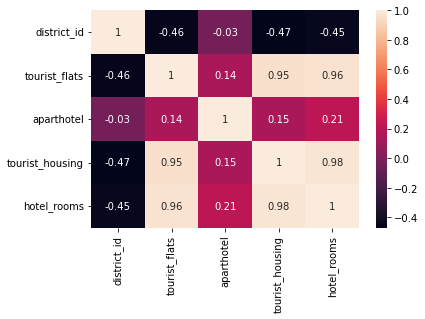

In [78]:
correlations_matrix = df_turism.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

As we can see there is a very high correlation between tourist flats and tourist housing with hotels so we are going to drop both

In [79]:
df_turism.columns

Index(['district_id', 'district_name', 'tourist_flats', 'aparthotel',
       'tourist_housing', 'hotel_rooms'],
      dtype='object')

In [80]:
df_turism = df_turism.drop(['tourist_flats', 'tourist_housing'], axis=1)

In [81]:
df_turism

,district_id,district_name,aparthotel,hotel_rooms
0,1,centro,1,19962
1,2,arganzuela,0,1576
2,3,retiro,0,1450
3,4,salamanca,2,4709
4,5,chamartin,2,2664
5,6,tetuan,1,2328
6,7,chamberi,0,3091
7,8,fuencarral-el pardo,0,1482
8,9,moncloa-aravaca,0,1904
9,10,latina,0,38


In [82]:
df_turism.to_csv('turism_districts.csv', index = False)

In [88]:
query1 = '''SELECT c.district_name, c.district_id, c.yearly_waste,
c.avg_income_person, c.avg_household_residents, c.residents,
u.university_centers, t.aparthotel, t.hotel_rooms 
FROM cleanedwaste_round2 as c
LEFT JOIN universities_district u
USING (district_id)
LEFT JOIN turism_districts t
USING (district_id)
ORDER BY district_id;'''

df = pd.read_sql_query(query1, engine)
df.head(22)

,district_name,district_id,yearly_waste,avg_income_person,avg_household_residents,residents,university_centers,aparthotel,hotel_rooms
0,centro,1,85006,17932.0,2.004294,134881.0,10.0,1,19962
1,arganzuela,2,42970,18473.0,2.366433,153830.0,1.0,0,1576
2,retiro,3,36880,22706.0,2.452674,119379.0,1.0,0,1450
3,salamanca,4,53533,26255.0,2.321615,146148.0,3.0,2,4709
4,chamartin,5,48791,28190.0,2.504550,145865.0,7.0,2,2664
5,tetuan,6,52020,15742.0,2.377567,157937.0,NaN,1,2328
6,chamberi,7,46282,24112.0,2.248690,139448.0,19.0,0,3091
7,fuencarral,8,78917,19551.0,2.718614,246021.0,17.0,0,1482
8,moncloa - aravaca,9,56453,24686.0,2.616057,119423.0,63.0,0,1904
9,latina,10,67966,12749.0,2.501171,238154.0,1.0,0,38


with this data we are going to drop barajas for the fact of the airport and we are goign to perform a linear regression model

In [89]:
df['university_centers'] = df['university_centers'].fillna(0)

In [90]:
df = df.drop(['district_name', 'district_id'], axis=1)

In [91]:
correlations_matrix = df.corr()
correlations_matrix

,yearly_waste,avg_income_person,avg_household_residents,residents,university_centers,aparthotel,hotel_rooms
yearly_waste,1.000000,-0.026999,-0.250388,0.813706,0.177945,-0.049665,0.393599
avg_income_person,-0.026999,1.000000,-0.460369,-0.206315,0.467285,0.219790,0.251475
avg_household_residents,-0.250388,-0.460369,1.000000,0.056115,-0.077490,-0.146554,-0.728479
residents,0.813706,-0.206315,0.056115,1.000000,-0.085557,-0.151283,-0.129231
university_centers,0.177945,0.467285,-0.077490,-0.085557,1.000000,-0.190499,0.118938
aparthotel,-0.049665,0.219790,-0.146554,-0.151283,-0.190499,1.000000,0.214322
hotel_rooms,0.393599,0.251475,-0.728479,-0.129231,0.118938,0.214322,1.000000


In [92]:
df = df.drop(['avg_household_residents'], axis=1)

In [105]:
y = df['yearly_waste']
X = df.drop('yearly_waste', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [106]:
from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler().fit(X_train) # need to keep transformer
X_train_normalized = transformer.transform(X_train)
X_train_norm = pd.DataFrame(X_train_normalized)
X_train_norm.columns = X_train.columns

In [107]:
X_train_norm.head(20)

,avg_income_person,residents,university_centers,aparthotel,hotel_rooms
0,0.313640,0.223636,0.063492,0.0,0.000000
1,0.000000,0.910471,0.015873,0.0,0.030269
2,0.864763,0.345017,0.015873,0.0,0.406390
3,0.008128,0.489597,0.000000,1.0,0.070067
4,0.394099,0.819815,0.000000,1.0,0.380886
5,0.575644,0.513839,0.015873,0.0,0.441704
6,0.170753,0.301194,0.000000,0.0,0.143498
7,0.157640,0.113462,0.000000,0.5,0.000000
8,0.087562,1.000000,0.015873,0.0,0.159473
9,0.663479,0.682591,0.000000,0.0,0.230101


In [108]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
lm.fit(X_train_norm,y_train)

LinearRegression()

In [109]:
X_test_normalized = transformer.transform(X_test)
X_test_norm = pd.DataFrame(X_test_normalized)
X_test_norm.columns = X_test.columns

In [110]:
from sklearn.metrics import r2_score
predictions = lm.predict(X_test_norm)
r2_score(y_test, predictions)

0.9114363274451548